In [1]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

from scfw.scopt import scopt
from scfw import dwd
from scfw.frank_wolfe import frank_wolfe

In [6]:
def run_fw(problem_name):
    out_dir = os.path.join('results', 'dwd')
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    results_file = os.path.join(out_dir, problem_name + '.pckl')
    if os.path.exists(results_file):
        with open(results_file, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {problem_name: {}}
    A, y = load_svmlight_file(os.path.join('../data', problem_name))
    # fix classes
    if max(y) == 2:
        y = 2 * y - 3
    # normalize
    #for i, row in enumerate(Phi):
    #    if np.sum(row.multiply(row)) != 0:
    #        A[i] = row.multiply(1 / np.sqrt(np.sum(row.multiply(row))))

    p, d = A.shape
    n = p + d + 1
    q = 2
    c = np.array([1] * p)

    Mf = (q + 2) / (q * (q + 1))**((q + 2) / 2)
    #nu = 2 * (q + 3) / (q + 2)
    nu = 3
    
    #running parameters
    R = 1
    u = 1
    x0 = np.array([0]*(d + 1) + [1]*p)
    terminate_tol = 1e-10
    
    #parameters for FW
    FW_params={
        'iter_FW':10000,
        'line_search_tol':1e-10,
        'rho':np.sqrt(n), #parameters for ll00
        'diam_X':2,
        'sigma_f':1,                   
    }
    
    
    sc_params={
        #parameters for SCOPT
        'iter_SC': 1000,
        'Lest': 'backtracking',#,'estimate', #estimate L
        'use_two_phase':False,
        #FISTA parameters
        'fista_type': 'mfista',
        'fista_tol': 1e-5,
        'fista_iter': 1000,
        #Conjugate Gradient Parameters
        'conj_grad_tol':1e-5,
        'conj_grad_iter':1000,
    }

    func_x = lambda x: dwd.dwd_val(A, y, c, x, n, d, p, q)
    func_beta = lambda x, s, beta, denom, denom_s: dwd.dwd_val(A, y, c, (1 - beta) * x + beta * s, n, d, p, q, (1 - beta) * denom + beta * denom_s)
    grad_x = lambda x, denom: dwd.dwd_grad(A, y, c, x, n, d, p, q, denom=denom)
    grad_beta = lambda x, s, beta, denom, denom_s: dwd.dwd_grad(A, y, c, (1 - beta) * x + beta * s, n, d, p, q, (1 - beta) * denom + beta * denom_s)
    hess_x = lambda s, exp_product: dwd.hess()
    hess_mult_x = lambda s, denom: dwd.hess_mult(A, y, c, s, n, d, p, q, denom=denom)
    hess_mult_vec_x = lambda s, exp_product: dwd.hess_mult_vec()
    extra_func = lambda x: A @ x[:d] + x[d] * y + x[(d + 1):]
    linear_oracle = lambda grad: dwd.linear_oracle(grad, d, p, R, u)
    # llo_oracle = lambda x, r, grad, rho: pr.llo_oracle(x, r, grad,rho)
    prox_func = lambda x, L: dwd.projection(x,r)

    run_alpha_policies = ['standard', 'line_search', 'backtracking', 'sc', 'sc_backtracking', 'sc_hybrid']

    for policy in run_alpha_policies:
        print(f'{policy} for {problem_name} started!')
        x, alpha_hist, Gap_hist, Q_hist, time_hist = frank_wolfe(func_x,
                           func_beta,                                      
                           grad_x,
                           grad_beta,
                           hess_mult_x,
                           extra_func,
                           Mf,
                           nu,
                           linear_oracle,                                                    
                           x0,
                           FW_params,
                           hess=None, 
                           lloo_oracle=None,                                                 
                           alpha_policy=policy,                                                    
                           eps=terminate_tol, 
                           print_every=1000, 
                           debug_info=False)
  
        results[problem_name][policy] = {
            'x': x,
            'alpha_hist': alpha_hist,
            'Gap_hist': Gap_hist,
            'Q_hist': Q_hist,
            'time_hist': time_hist,
        }

#        with open(results_file, 'wb') as f:
#            pickle.dump(results, f)    

        print(f'{policy} for {problem_name} finished!')
    return results

In [7]:
files = ['a9a']

for problem_name in files:
    results = run_fw(problem_name)

standard for a1a started!
********* Algorithm starts *********
iter=1, stepsize=6.67e-01, criterion=6.84e-01, upper_bound=1605.9304347826087, lower_bound=-42.79381675838954, real_Gap=1.65e+03, f_val=1605.9304347826087
iter=1000, stepsize=2.00e-03, criterion=6.84e-04, upper_bound=-39.914958760690766, lower_bound=-39.91824664846087, real_Gap=3.29e-03, f_val=-39.914958760690766
iter=2000, stepsize=9.99e-04, criterion=3.42e-04, upper_bound=-39.91742402289599, lower_bound=-39.918246543176856, real_Gap=8.23e-04, f_val=-39.91742402289599
iter=3000, stepsize=6.66e-04, criterion=2.28e-04, upper_bound=-39.917880789779396, lower_bound=-39.918246380681595, real_Gap=3.66e-04, f_val=-39.917880789779396
iter=4000, stepsize=5.00e-04, criterion=1.71e-04, upper_bound=-39.91804068101654, lower_bound=-39.918246380681595, real_Gap=2.06e-04, f_val=-39.91804068101654
iter=5000, stepsize=4.00e-04, criterion=1.37e-04, upper_bound=-39.918114717433255, lower_bound=-39.9182463695786, real_Gap=1.32e-04, f_val=-39.

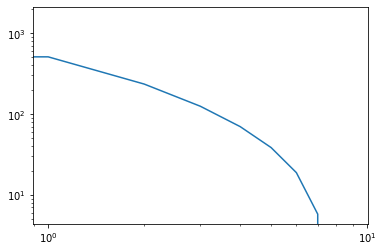

In [22]:
for policy in results['a1a'].keys():
    plt.plot(results['a1a'][policy]['Q_hist'][:10])
    plt.xscale('log')
    plt.yscale('log')

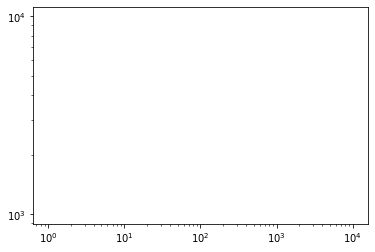

In [13]:
plt.plot(results['a1a']['sc']['Q_hist'])
plt.xscale('log')
plt.yscale('log')

In [19]:
results['a1a']['line_search']['Q_hist'][:10]

[1605.9304347826087,
 -39.87506038395894,
 -39.914401147499,
 -39.91450129037479,
 -39.91477682614629,
 -39.91502687173042,
 -39.915230800918664,
 -39.915419447324794,
 -39.915577561263184,
 -39.91572517639667]

In [20]:
results['a1a']['sc']['Q_hist'][:10]

[1605.9304347826087,
 -39.875060479720396,
 -39.90183794619601,
 -39.914311143004184,
 -39.915734882823784,
 -39.91574539431036,
 -39.91587600448429,
 -39.91600008665281,
 -39.91610099243266,
 -39.91620189357121]

In [2]:
A, y = load_svmlight_file(os.path.join('../data', 'a1a'))
# fix classes
if max(y) == 2:
    y = 2 * y - 3
# normalize
#for i, row in enumerate(Phi):
#    if np.sum(row.multiply(row)) != 0:
#        A[i] = row.multiply(1 / np.sqrt(np.sum(row.multiply(row))))

p, d = A.shape
n = p + d + 1
q = 2
c = np.array([1] * p)
R = 1
u = 1
x0 = np.array([0]*(d + 1) + [1]*p)

In [3]:
val, denom = dwd.dwd_val(A, y, c, x0, n, d, p, q)
grad = dwd.dwd_grad(A, y, c, x0, n, d, p, q, denom=denom)
s = dwd.linear_oracle(grad, d, p, 1, 1)

In [4]:
np.dot(grad, s)

-45.58512110621393

In [29]:
hess_mult

5.833043468344695

In [26]:
denom = 1 / (denom**(2 + 2))

In [23]:
s - x0

array([ 0.,  0.,  0., ..., -1., -1., -1.])

In [30]:
hess_mult_x = lambda s, denom: dwd.hess_mult(A, y, c, s, n, d, p, q, denom=denom)

In [31]:
hess_mult_x(s-x0, denom)

5.833043468344695

In [36]:
a = np.array([1, 2, 3, 4, 5])

In [46]:
mask = ([bool(i % 2) for i in range(5)])

In [48]:
a[mask] = a[mask] * (-1)

In [53]:
np.linalg.norm(a / np.linalg.norm(a))

1.0

In [51]:
a

array([ 1, -2,  3, -4,  5])